<a href="https://colab.research.google.com/github/arielkeren/neural-network/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class Initialization:
  @staticmethod
  def get(name):
    match name.lower():
      case "xavier":
        return Initialization.xavier
      case "he":
        return Initialization.he
      case "zeros":
        return Initialization.zeros
      case _:
        return Initialization.he

  @staticmethod
  def xavier(n_in, n_out):
    return np.random.randn(n_in, n_out) * np.sqrt(1. / n_in)

  @staticmethod
  def he(n_in, n_out):
    return np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)

  @staticmethod
  def zeros(n_in, n_out):
    return np.zeros((n_in, n_out))

class Loss:
  @staticmethod
  def get(name):
    match name.lower():
      case "mean_squared_error":
        return Loss.mean_squared_error, Loss.mean_squared_error_derivative
      case "binary_cross_entropy":
        return Loss.binary_cross_entropy, Loss.binary_cross_entropy_derivative
      case "categorical_cross_entropy":
        return Loss.categorical_cross_entropy, Loss.categorical_cross_entropy_derivative
      case _:
        return Loss.mean_squared_error, Loss.mean_squared_error_derivative

  @staticmethod
  def simplify(loss, output_activation):
    loss = loss.lower()
    output_activation = output_activation.lower()

    if (loss == "binary_cross_entropy" and output_activation == "sigmoid"):
      return Loss.mean_squared_error_derivative, Activation.linear_derivative

    if (loss == "categorical_cross_entropy" and output_activation == "softmax"):
      return Loss.mean_squared_error_derivative, Activation.linear_derivative

    return Loss.get(loss)[1], Activation.get(output_activation)[1]

  @staticmethod
  def mean_squared_error(y_true, y_pred):
    error = y_pred - y_true
    return np.mean(error * error)

  @staticmethod
  def mean_squared_error_derivative(y_true, y_pred):
    return y_pred - y_true

  @staticmethod
  def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

  @staticmethod
  def binary_cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -(y_true / y_pred - (1 - y_true) / (1 - y_pred))

  @staticmethod
  def categorical_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))

  @staticmethod
  def categorical_cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -y_true / y_pred

class Activation:
  @staticmethod
  def get(name):
    match name.lower():
      case "linear":
        return Activation.linear, Activation.linear_derivative
      case "sigmoid":
        return Activation.sigmoid, Activation.sigmoid_derivative
      case "relu":
        return Activation.relu, Activation.relu_derivative
      case "softmax":
        return Activation.softmax, Activation.softmax_derivative
      case _:
        return Activation.relu, Activation.relu_derivative

  @staticmethod
  def linear(x):
    return x

  @staticmethod
  def linear_derivative(x):
    return np.ones_like(x)

  @staticmethod
  def sigmoid(x):
    return 1. / (1. + np.exp(-x))

  @staticmethod
  def sigmoid_derivative(x):
    return Activation.sigmoid(x) * (1. - Activation.sigmoid(x))

  @staticmethod
  def relu(x):
    return x * (x > 0)

  @staticmethod
  def relu_derivative(x):
    return 1. * (x > 0)

  @staticmethod
  def softmax(x):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

  @staticmethod
  def softmax_derivative(x):
    softmax_output = Activation.softmax(x)

    num_samples = softmax_output.shape[0]
    num_classes = softmax_output.shape[1]

    jacobian_matrix = np.zeros((num_samples, num_classes, num_classes))

    for i in range(num_samples):
        for j in range(num_classes):
            for k in range(num_classes):
                if j == k:
                    jacobian_matrix[i, j, k] = softmax_output[i, j] * (1 - softmax_output[i, j])
                else:
                    jacobian_matrix[i, j, k] = -softmax_output[i, j] * softmax_output[i, k]

    return jacobian_matrix

In [ ]:
from dataclasses import dataclass

@dataclass
class Layer:
  num_neurons: int
  activation: str
  initialization: str

In [ ]:
import matplotlib.pyplot as plt

class NeuralNetwork:
  def __init__(self, num_inputs, loss):
    self.num_inputs = num_inputs
    self.loss_name = loss
    self.loss, self.loss_derivative = Loss.get(loss)
    self.weights = []
    self.biases = []
    self.activations = []
    self.derivatives = []
    self.layers = []
    self.error_history = []

  def add(self, num_neurons, activation, initialization):
    if len(self.layers) == 0:
      self.weights.append(Initialization.get(initialization)(self.num_inputs, num_neurons))
    else:
      self.weights.append(Initialization.get(initialization)(self.weights[-1].shape[1], num_neurons))

    self.layers.append(Layer(num_neurons, activation, initialization))
    self.biases.append(np.zeros(num_neurons))

    activation_function, derivative = Activation.get(activation)
    self.activations.append(activation_function)
    self.derivatives.append(derivative)

  def remove(self):
    if len(self.layers) == 0:
      return

    self.weights = self.weights[:-1]
    self.biases = self.biases[:-1]
    self.activations = self.activations[:-1]
    self.derivatives = self.derivatives[:-1]
    self.layers = self.layers[:-1]

  def summary(self):
    print("----------")

    print("Loss:", self.loss_name)
    print("Input Layer:", self.num_inputs)

    total_weights = 0
    total_biases = 0
    last_num_neurons = self.num_inputs

    for index, layer in enumerate(self.layers[:-1]):
      total_weights += layer.num_neurons * last_num_neurons
      total_biases += layer.num_neurons

      print("\n--- Hidden Layer", index + 1, "---")
      print("Neurons:", layer.num_neurons)
      print("Activation:", layer.activation)
      print("Initialization:", layer.initialization)
      print("Weights:", layer.num_neurons * last_num_neurons)
      print("Biases:", layer.num_neurons)

      last_num_neurons = layer.num_neurons

    output_layer = self.layers[-1]
    total_weights += output_layer.num_neurons * last_num_neurons
    total_biases += output_layer.num_neurons

    print("\n--- Output Layer ---")
    print("Neurons:", output_layer.num_neurons)
    print("Activation:", output_layer.activation)
    print("Initialization:", output_layer.initialization)
    print("Weights:", output_layer.num_neurons * last_num_neurons)
    print("Biases:", output_layer.num_neurons)

    print("\nTotal weights:", total_weights)
    print("Total biases:", total_biases)
    print("Total parameters:", total_weights + total_biases)

    if len(self.error_history) > 0:
      print("Loss:", self.error_history[-1])

    print("----------")

    if len(self.error_history) > 0:
      plt.figure()
      plt.plot(self.error_history, label="Loss")
      plt.legend()
      plt.show()

  def predict(self, x):
    for weights, biases, activation in zip(self.weights, self.biases, self.activations):
        x = activation(x @ weights + biases)
    return x

  def fit(self, x, y, batch_size, learning_rate, epochs):
    self.loss_derivative, self.derivatives[-1] = Loss.simplify(self.loss_name, self.layers[-1].activation)

    error_history = []
    num_samples = y.shape[0]

    for _ in range(epochs):
      random_indices = np.random.permutation(num_samples)[:batch_size]
      batch_x = x[random_indices]
      batch_y = y[random_indices]

      output_a = batch_x
      z_results = []
      a_results = []

      for weights, biases, activation in zip(self.weights, self.biases, self.activations):
        a_results.append(output_a)
        z = output_a @ weights + biases
        a = activation(z)
        z_results.append(z)
        output_a = a

      error = self.loss_derivative(batch_y, output_a)

      derivatives = [derivative(z_result) for derivative, z_result in zip(self.derivatives, z_results)][::-1]

      change = error * derivatives[0]
      changes = [change]

      for derivative, weights in zip(derivatives[1:], self.weights[::-1]):
        change = (change @ weights.T) * derivative
        changes.append(change)

      changes = changes[::-1]

      for index in range(len(self.weights)):
        self.biases[index] -= learning_rate * np.mean(changes[index], axis=0)
        self.weights[index] -= (learning_rate * (changes[index].T @ a_results[index])).T

      error_history.append(np.mean(self.loss(batch_y, output_a)))

    self.error_history = error_history

In [ ]:
class BinaryClassifier(NeuralNetwork):
  def __init__(self, num_inputs):
    super().__init__(num_inputs, "binary_cross_entropy")
    super().add(1, "sigmoid", "xavier")

  def add(self, num_neurons, activation, initialization):
    super().remove()
    super().add(num_neurons, activation, initialization)
    super().add(1, "sigmoid", "xavier")

  def fit(self, x, y, batch_size, learning_rate, epochs):
    super().fit(x, y.reshape(-1, 1), batch_size, learning_rate, epochs)

  def test(self, x, y):
    print("Accuracy:", str(round(100 * np.mean((np.reshape(model.predict(x), x.shape[0]) >= .5) == y), 3)) + "%")

class Classifier(NeuralNetwork):
  def __init__(self, num_inputs, num_classes):
    super().__init__(num_inputs, "categorical_cross_entropy")
    super().add(num_classes, "softmax", "xavier")

  def add(self, num_neurons, activation, initialization):
    num_classes = self.layers[-1].num_neurons
    super().remove()
    super().add(num_neurons, activation, initialization)
    super().add(num_classes, "softmax", "xavier")

  def fit(self, x, y, batch_size, learning_rate, epochs):
    super().fit(x, np.eye(self.layers[-1].num_neurons)[y], batch_size, learning_rate, epochs)

  def test(self, x, y):
    print("Accuracy:", str(round(100 * np.mean(np.argmax(model.predict(x), axis=1) == y), 3)) + "%")

class Perceptron:
  def __init__(self, num_inputs, activation, initialization):
    self.perceptron = NeuralNetwork(num_inputs, "mean_squared_error")
    self.perceptron.add(1, activation, initialization)

  def summary(self):
    self.perceptron.summary()

  def predict(self, x):
    return self.perceptron.predict(x)

  def fit(self, x, y, batch_size, learning_rate, epochs):
    self.perceptron.fit(x, y.reshape(-1, 1), batch_size, learning_rate, epochs)

class LinearRegression(Perceptron):
  def __init__(self, num_inputs):
    super().__init__(num_inputs, "linear", "zeros")

  def test(self, x, y):
    print("Average error:", round(np.mean(abs((np.reshape(model.predict(x), x.shape[0]) - y))), 3))

class LogisticRegression(Perceptron):
  def __init__(self, num_inputs):
    super().__init__(num_inputs, "sigmoid", "xavier")

  def test(self, x, y):
    print("Accuracy:", str(round(100 * np.mean((np.reshape(model.predict(x), x.shape[0]) >= .5) == y), 3)) + "%")

In [ ]:
def split_data(x, y, test_percentage=20):
  indices = np.arange(y.shape[0])
  np.random.shuffle(indices)
  split = int(y.shape[0] * test_percentage / 100)

  x = x[indices]
  y = y[indices]

  x_train = x[split:]
  y_train = y[split:]

  x_test = x[:split]
  y_test = y[:split]

  return (x_train, y_train, x_test, y_test)

def load_binary_x(file_path):
  with open(file_path, "rb") as file:
      file.read(16)
      binary_data = file.read()

  numpy_data = np.frombuffer(binary_data, dtype=np.uint8)
  num_images = numpy_data.size // 784
  data = numpy_data.reshape(num_images, 784)
  data = data / 255
  return data

def load_binary_y(file_path):
  with open(file_path, "rb") as file:
      file.read(8)
      binary_data = file.read()

  return np.frombuffer(binary_data, dtype=np.uint8)

Handwritten Digit Recognition

Accuracy: 96.79%
----------
Loss: categorical_cross_entropy
Input Layer: 784

--- Hidden Layer 1 ---
Neurons: 128
Activation: relu
Initialization: he
Weights: 100352
Biases: 128

--- Hidden Layer 2 ---
Neurons: 32
Activation: relu
Initialization: he
Weights: 4096
Biases: 32

--- Output Layer ---
Neurons: 10
Activation: softmax
Initialization: xavier
Weights: 320
Biases: 10

Total weights: 104768
Total biases: 170
Total parameters: 104938
Loss: 0.08984444384580431
----------


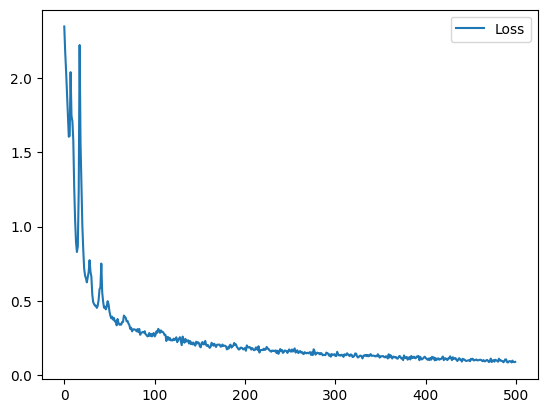

In [ ]:
x_train = load_binary_x("digits_x_train")
y_train = load_binary_y("digits_y_train")
x_test = load_binary_x("digits_x_test")
y_test = load_binary_y("digits_y_test")

model = Classifier(28 * 28, 10)
model.add(128, "relu", "he")
model.add(32, "relu", "he")
model.fit(x_train, y_train, 4096, 0.0001, 500)
model.test(x_test, y_test)
model.summary()

Iris Classification

Accuracy: 93.333%
----------
Loss: categorical_cross_entropy
Input Layer: 4

--- Hidden Layer 1 ---
Neurons: 16
Activation: relu
Initialization: he
Weights: 64
Biases: 16

--- Hidden Layer 2 ---
Neurons: 8
Activation: relu
Initialization: he
Weights: 128
Biases: 8

--- Output Layer ---
Neurons: 3
Activation: softmax
Initialization: xavier
Weights: 24
Biases: 3

Total weights: 216
Total biases: 27
Total parameters: 243
Loss: 3.117779436017185e-05
----------


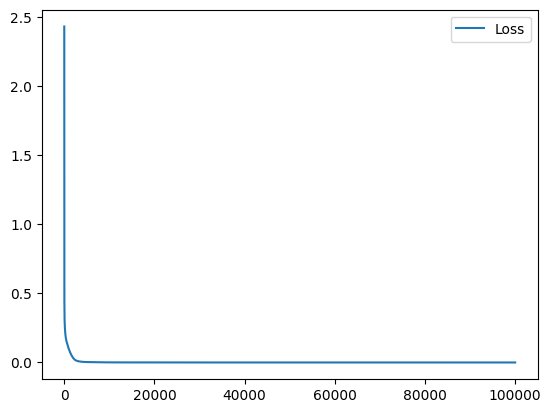

In [ ]:
import pandas as pd

iris_to_number = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
df = pd.read_csv("/content/iris.csv")
y = df.Species.apply(lambda value: iris_to_number[value]).values
df = df.drop(columns=["Species", "Id"])
df = (df - df.mean()) / df.std()
x = df.values
x_train, y_train, x_test, y_test = split_data(x, y)

model = Classifier(4, 3)
model.add(16, "relu", "he")
model.add(8, "relu", "he")
model.fit(x_train, y_train, 120, 0.001, 100000)
model.test(x_test, y_test)
model.summary()

Gender Binary Classification

Accuracy: 100.0%
----------
Loss: binary_cross_entropy
Input Layer: 3

--- Hidden Layer 1 ---
Neurons: 8
Activation: relu
Initialization: he
Weights: 24
Biases: 8

--- Output Layer ---
Neurons: 1
Activation: sigmoid
Initialization: xavier
Weights: 8
Biases: 1

Total weights: 32
Total biases: 9
Total parameters: 41
Loss: 0.00026226717537245864
----------


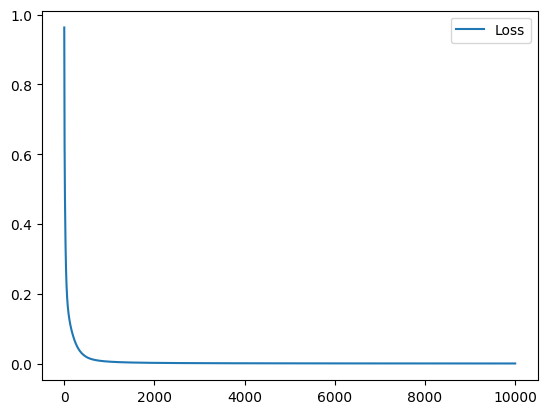

In [ ]:
df = pd.read_csv("/content/gender.csv")
y = df[df.columns[3]].apply(lambda value: 0 if value == "זכר" else 1).values
df = df.drop(columns=df.columns[3])
df = (df - df.mean()) / df.std()
x = df.values
x_train, y_train, x_test, y_test = split_data(x, y)

model = BinaryClassifier(3)
model.add(8, "relu", "he")
model.fit(x_train, y_train, x_train.shape[0], 0.01, 10000)
model.test(x_test, y_test)
model.summary()

Height Linear Regression

Average error: 0.472
----------
Loss: mean_squared_error
Input Layer: 2

--- Output Layer ---
Neurons: 1
Activation: linear
Initialization: zeros
Weights: 2
Biases: 1

Total weights: 2
Total biases: 1
Total parameters: 3
Loss: 0.23045843014346595
----------


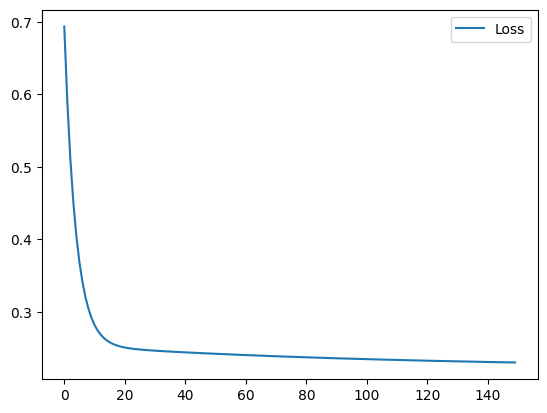

In [ ]:
df = pd.read_csv("/content/gender.csv")
df = df.drop(columns=df.columns[3])
df = (df - df.mean()) / df.std()
y = df[df.columns[0]].values
df = df.drop(columns=df.columns[0])
x = df.values
x_train, y_train, x_test, y_test = split_data(x, y)

model = LinearRegression(2)
model.fit(x_train, y_train, x_train.shape[0], 0.01, 150)
model.test(x_test, y_test)
model.summary()

OR Logistic Regression

Accuracy: 100.0%
----------
Loss: mean_squared_error
Input Layer: 2

--- Output Layer ---
Neurons: 1
Activation: sigmoid
Initialization: xavier
Weights: 2
Biases: 1

Total weights: 2
Total biases: 1
Total parameters: 3
Loss: 0.00419318081487945
----------


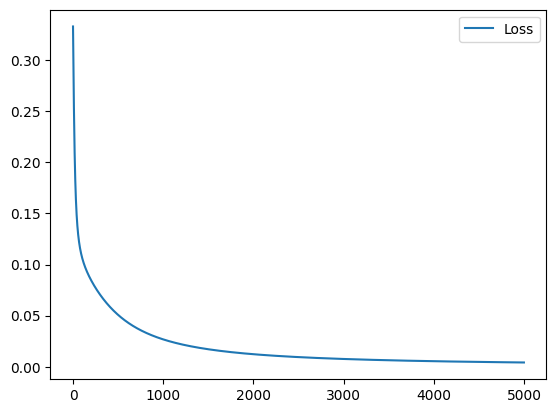

In [ ]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 1])

model = LogisticRegression(2)
model.fit(x, y, 4, 0.1, 5000)
model.test(x, y)
model.summary()

Function Approximation

----------
Loss: mean_squared_error
Input Layer: 1

--- Hidden Layer 1 ---
Neurons: 16
Activation: relu
Initialization: he
Weights: 16
Biases: 16

--- Hidden Layer 2 ---
Neurons: 16
Activation: relu
Initialization: he
Weights: 256
Biases: 16

--- Output Layer ---
Neurons: 1
Activation: linear
Initialization: zeros
Weights: 16
Biases: 1

Total weights: 288
Total biases: 33
Total parameters: 321
Loss: 0.14655558168348856
----------


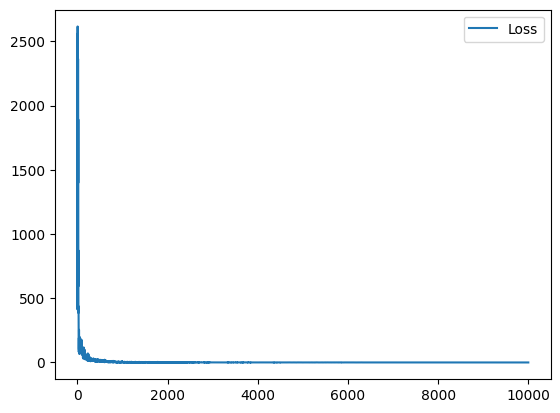

In [ ]:
nums = np.linspace(0, 10, num=1000)
x = np.expand_dims(nums, axis=-1) / 10
y = nums * nums

model = NeuralNetwork(1, "mean_squared_error")
model.add(16, "relu", "he")
model.add(16, "relu", "he")
model.add(1, "linear", "zeros")
model.fit(x, y.reshape(-1, 1), 16, 0.0001, 10000)
model.summary()